<a href="https://colab.research.google.com/github/aritrasen87/LLM_RAG_Model_Deployment/blob/main/LangGraph_9_ReAct_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install langchain-core langchain-community langgraph langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.0/383.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49

In [6]:
# Key and llm initialization
import os
from google.colab import userdata
from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY')

In [7]:
# Tavily tool initialization
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, tavily_tool]

llm = ChatOpenAI(model="gpt-4o-mini")

llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [9]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic and search on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

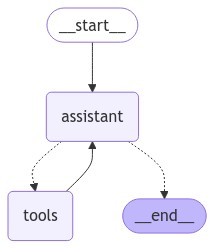

In [11]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
app = StateGraph(MessagesState)

# Define nodes: these do the work
app.add_node("assistant", assistant)
app.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
app.add_edge(START, "assistant")
app.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
app.add_edge("tools", "assistant")
react_graph = app.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [15]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_d3UwzZ8BmFgvWgV0FEEbFDhT)
 Call ID: call_d3UwzZ8BmFgvWgV0FEEbFDhT
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_RVXY8yHv6NvqKHptQH09fQxj)
 Call ID: call_RVXY8yHv6NvqKHptQH09fQxj
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  multiply (call_A4BH7Pt834g2dYcG8Q23LXeD)
 Call ID: call_A4BH7Pt834g2dYcG8Q23LXeD
  Args:
    a: 14
    b: 0.2
================================= Tool Message ===========

In [18]:
messages = [HumanMessage(content="Tell me how many centruries score by Virat Kohli and then tell me the number if we add 30 more centuries to that")]
messages = react_graph.invoke({"messages": messages})

In [19]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Tell me how many centruries score by Virat Kohli and then tell me the number if we add 30 more centuries to that
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_PWduOcAfq0Lj78bE0xBivmtx)
 Call ID: call_PWduOcAfq0Lj78bE0xBivmtx
  Args:
    query: Virat Kohli total centuries scored
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://cricnerds.com/cricket-stats/virat-kohli-centuries-list-of-odi-test-centuries-made-by-virat-kohli/", "content": "List of Virat Kohli centuries in Test cricket. The total number of Virat Kohli centuries in Test cricket is 29. Kohli scored his first Test century against Australia at Adelaide Oval in 2012. Virat scored his highest Test individual score of 254 against South Africa at Pune in 2019."}, {"url": "https://www.wiki